In [10]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import models
import random

In [ ]:
"""CODE TO MERGE RESULTS 
def combine_activation_results(input_folder, output_file):
    combined_results = {}

    # List all JSON files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('_activation_results.json'):
            layer_name = filename.replace('_activation_results.json', '')
            file_path = os.path.join(input_folder, filename)

            with open(file_path, 'r') as f:
                data = json.load(f)

            # Add to the combined dictionary
            combined_results[layer_name] = data

    with open(output_file, 'w') as f:
        json.dump(combined_results, f)

    print(f"Combined results saved to {output_file}")

input_folder = '/home/fonta42/Desktop/masters-degree/experiments/conv-probe-layers-results'  
output_file = '/home/fonta42/Desktop/masters-degree/experiments/conv-probe-layers-results/resnet18_layers_iou_results.json'
combine_activation_results(input_folder, output_file) """

In [11]:
def load_iou_results(file_path):
    with open(file_path, 'r') as f:
        iou_results = json.load(f)
    return iou_results

def get_top_k_layers(iou_results, metric='iou', phase='val', k=10, highest=True):
    # Prepare a list of tuples (layer_name, channel_id, max_value)
    layers_max_values = []
    for layer_name, channels_data in iou_results.items():
        for channel_id, data in channels_data.items():
            if metric == 'iou':
                values = data[f'{phase}_iou']
            elif metric == 'loss':
                values = data[f'{phase}_loss']
            else:
                raise ValueError("Metric must be 'iou' or 'loss'")
            max_value = np.max(values)  # Get the max value
            layers_max_values.append((layer_name, channel_id, max_value))

    # Sort the list based on max_value
    layers_max_values.sort(key=lambda x: x[2], reverse=highest if metric == 'iou' else not highest)

    # Get the top k channels across layers
    top_k_layers = layers_max_values[:k]
    return top_k_layers

def plot_top_k_losses(iou_results, top_k_layers, loss_type="train"):
    plt.figure(figsize=(18, 9))

    for layer_name, channel_id, _ in top_k_layers:
        data = iou_results[layer_name][channel_id]
        epochs = range(1, len(data['train_loss']) + 1)
        if loss_type == "train":
            plt.plot(epochs, data['train_loss'], label=f'Train Loss {layer_name} Channel {channel_id}', alpha=0.7)
        else:
            plt.plot(epochs, data['val_loss'], label=f'Val Loss {layer_name} Channel {channel_id}', linestyle='--', alpha=0.7)

    plt.title(f'Top {len(top_k_layers)} Channels - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_top_k_ious(iou_results, top_k_layers, iou_type="train"):
    plt.figure(figsize=(18, 9))

    for layer_name, channel_id, _ in top_k_layers:
        data = iou_results[layer_name][channel_id]
        epochs = range(1, len(data['train_iou']) + 1)
        if iou_type == "train":
            plt.plot(epochs, data['train_iou'], label=f'Train IoU {layer_name} Channel {channel_id}', alpha=0.7)
        else:
            plt.plot(epochs, data['val_iou'], label=f'Val IoU {layer_name} Channel {channel_id}', linestyle='--', alpha=0.7)

    plt.title(f'Top {len(top_k_layers)} Channels - IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

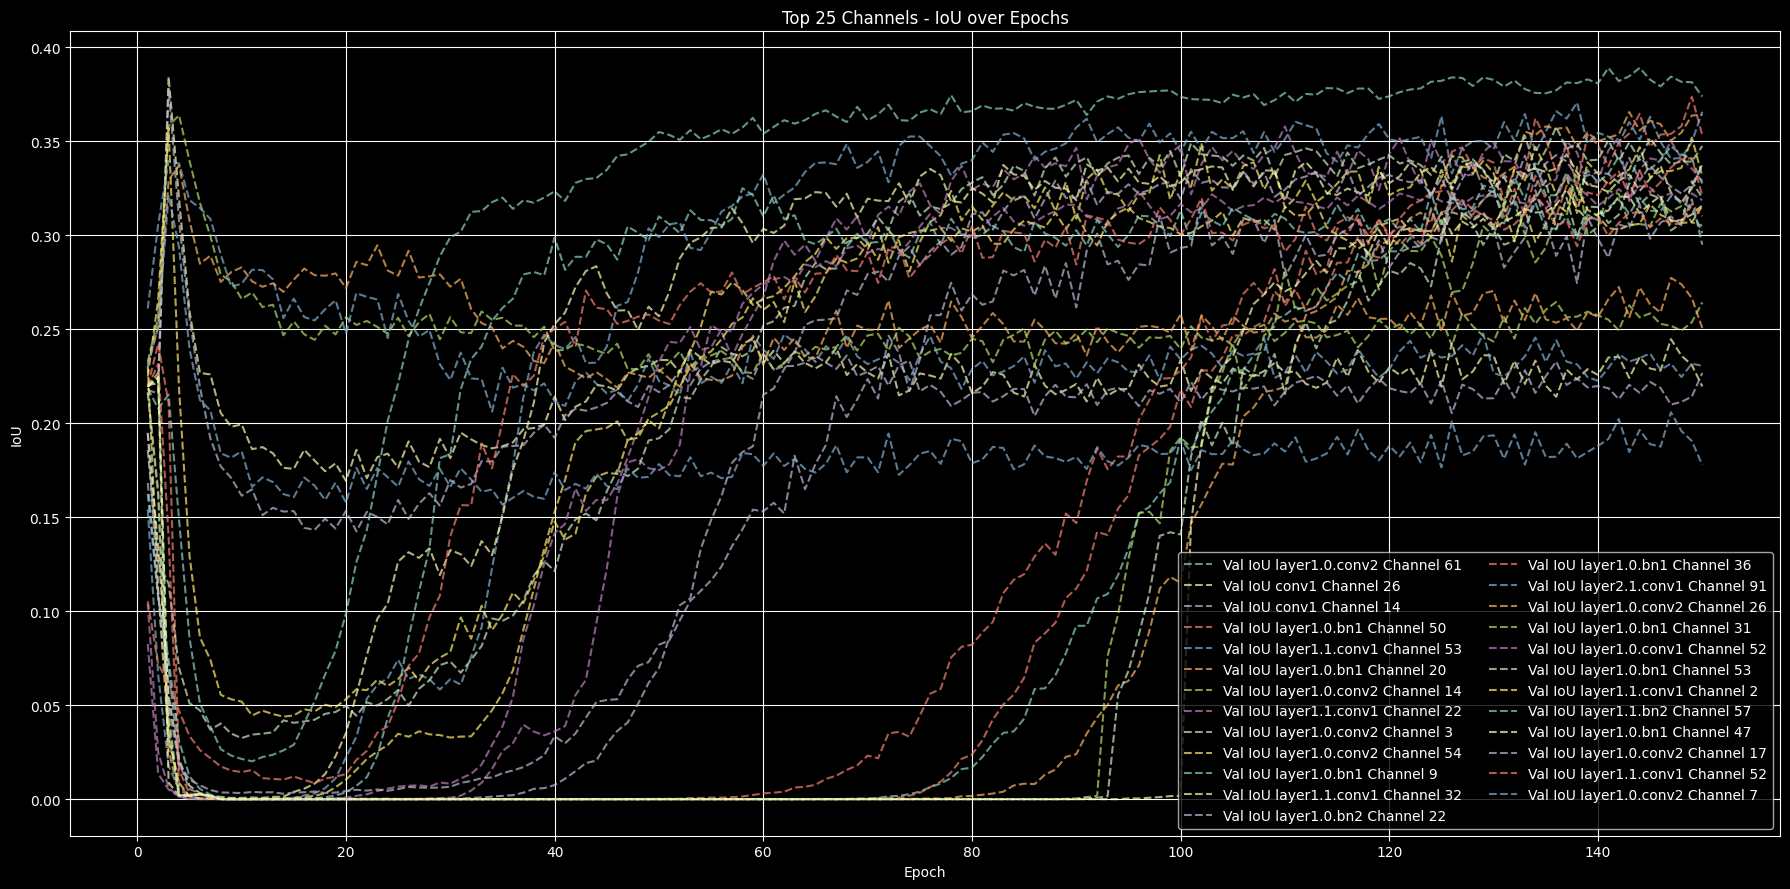

In [15]:
iou_results_file = '/home/fonta42/Desktop/masters-degree/experiments/bce-conv-probe/conv-probe-layers-results/resnet18_layers_iou_results.json'
iou_results = load_iou_results(iou_results_file)

# For highest final IoU
top_k_iou_layers = get_top_k_layers(iou_results, metric='iou', phase='val', k=25, highest=True)
plot_top_k_ious(iou_results, top_k_iou_layers, iou_type='val')

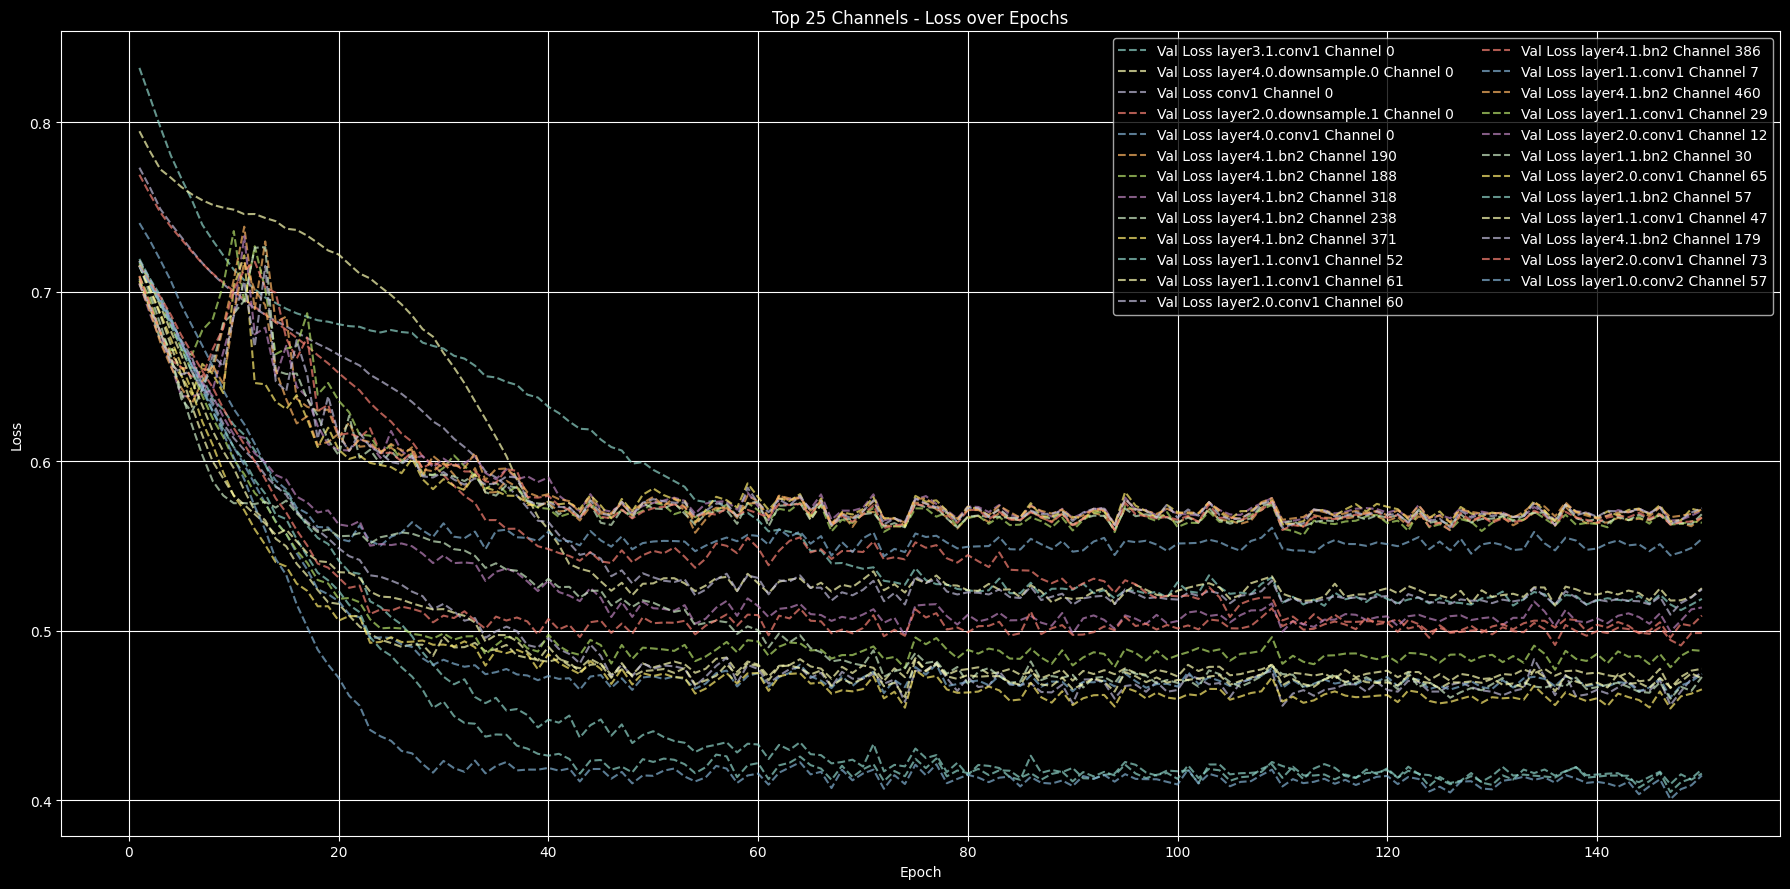

In [16]:
# For lowest final Loss
top_k_loss_layers = get_top_k_layers(iou_results, metric='loss', phase='val', k=25, highest=False)
plot_top_k_losses(iou_results, top_k_loss_layers, loss_type='val')

In [ ]:
# Dataset
import sys
sys.path.append('../data/vess-map/')
from vess_map_dataset import VessMapDataset

# Define paths
image_dir = '../data/vess-map/images'
mask_dir = '../data/vess-map/labels'
skeleton_dir = '../data/vess-map/skeletons'

image_size = 256

# Initialize the dataset
vess_dataset = VessMapDataset(image_dir, mask_dir, skeleton_dir, image_size, apply_transform=False)

# Get the train and test loaders
train_loader, test_loader = vess_dataset.vess_map_dataloader(batch_size=80, train_size=0.8)

In [ ]:
class ConvProbe(nn.Module):
    def __init__(self, model, layer_name, output_size=(256, 256), seed=None, single_channel=True):
        super(ConvProbe, self).__init__()

        # Load pre-trained ResNet-18 model
        self.model =  model
        self.layer_name = layer_name
        self.output_size = output_size
        self.single_channel = single_channel

        # Freeze model weights to prevent training
        for param in self.model.parameters():
            param.requires_grad = False

        # Get number of channels from the specified layer
        in_channels = 1 if self.single_channel else self.get_layer_channels(layer_name)


        # Initialize the first convolutional layer (to be trained)
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,  # Numbers of channels for the activation
            out_channels=1,  
            kernel_size=3,
            padding=1  # Preserve spatial dimensions
        )

        # Initialize the second convolutional layer (to be trained)
        self.conv2 = nn.Conv2d(
            in_channels=1,  # Input channels from conv1
            out_channels=1,  # Single output channel for binary segmentation
            kernel_size=3,
            padding=1  # Preserve spatial dimensions
        )

        # Set a fixed random seed for consistency, if provided
        if seed is not None:
            self.set_seed(seed)

        # Register a hook to capture activations from the specified layer
        self.activations = {}
        self.register_hook()

    # Helper function to set random seed
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Helper function to get the number of channels from the specified layer
    def get_layer_channels(self, layer_name):
        # Iterate over the named modules to find the specified layer
        for name, module in self.model.named_modules():
            if name == layer_name:
                if hasattr(module, 'out_channels'):
                    return module.out_channels
                elif hasattr(module, 'num_features'):
                    return module.num_features  # For BatchNorm layers
                else:
                    raise ValueError(f"Layer {layer_name} does not have out_channels or num_features.")
        raise ValueError(f"Layer {layer_name} not found.")

    # Register a forward hook to capture activations
    def register_hook(self):
        def hook_fn(module, input, output):
            self.activations[self.layer_name] = output

        # Register the hook on the specified layer
        for name, module in self.model.named_modules():
            if name == self.layer_name:
                module.register_forward_hook(hook_fn)
                break

    # Forward pass through the model
    def forward(self, x, channel_idx=None):
        _ = self.model(x)  # Forward pass to get activations
        activation = self.activations[self.layer_name]  # Retrieve the stored activation

        # Select a specific channel if provided
        if channel_idx is not None:
            if channel_idx < 0 or channel_idx >= activation.size(1):
                raise ValueError(f"Channel index {channel_idx} is out of bounds for activation with {activation.size(1)} channels.")
            activation = activation[:, channel_idx:channel_idx+1, :, :]  # Select the specific channel

        # Apply the first convolutional layer
        activation = self.conv1(activation)

        # Interpolate activation to match the desired output size
        activation = F.interpolate(activation, size=self.output_size, mode='bilinear', align_corners=True)

        # Apply the second convolutional layer
        out = self.conv2(activation) 
        
        return out

In [ ]:
def train_and_save_conv_probe(
    model, layer_name, channel_idx, train_loader, test_loader, image_size, device,
    num_epochs=10, lr=0.001, output_dir='./segmentation_outputs'
):
    # Initialize the ConvProbe model
    conv_probe = ConvProbe(
        model=model,
        layer_name=layer_name,
        output_size=(image_size, image_size),
        single_channel=True
    ).to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(conv_probe.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in range(num_epochs):
        conv_probe.train()
        total_loss = 0.0
        for images, masks, _ in train_loader:
            images = images.to(device)
            masks = masks.to(device).float()

            optimizer.zero_grad()
            outputs = conv_probe(images, channel_idx=int(channel_idx))
            outputs = outputs.squeeze(1)
            masks = masks.squeeze(1)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluation and saving outputs
    conv_probe.eval()
    os.makedirs(output_dir, exist_ok=True)
    layer_output_dir = os.path.join(output_dir, f'{layer_name}_channel_{channel_idx}')
    os.makedirs(layer_output_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (images, masks, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = conv_probe(images, channel_idx=int(channel_idx))
            outputs = outputs.cpu()

            # Binarize the outputs
            outputs = (outputs > 0.5).float()

            # Save each pair of original image and output
            for i in range(outputs.size(0)):
                original_image = images[i, 0, :, :].cpu().numpy()  # Convert to NumPy array
                mask = masks[i, 0, :, :].cpu().numpy()  # Convert to NumPy array
                output_image = outputs[i, 0, :, :].numpy()

                # Plot original and output side by side
                fig, axes = plt.subplots(1, 3, figsize=(10, 5))
                axes[0].imshow(original_image, cmap='gray')
                axes[0].set_title("Original Image")
                axes[0].axis('off')

                axes[1].imshow(output_image, cmap='gray')
                axes[1].set_title("Model Output")
                axes[1].axis('off')
                
                axes[2].imshow(mask, cmap='gray')
                axes[2].set_title("Image Mask")
                axes[2].axis('off')

                # Save the plot
                image_filename = os.path.join(
                    layer_output_dir, f'output_{idx * outputs.size(0) + i}.png'
                )
                plt.tight_layout()
                plt.savefig(image_filename, bbox_inches='tight')
                plt.close(fig)

    # Save the trained ConvProbe model
    """ model_save_path = os.path.join(layer_output_dir, 'conv_probe.pth')
    torch.save(conv_probe.state_dict(), model_save_path) """

    # Clean up
    del conv_probe, optimizer, criterion
    del train_loader, test_loader
    torch.cuda.empty_cache()

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over the best layers and channels
for layer_name, channel_idx, final_value in top_k_iou_layers:
    print(f"Training ConvProbe for Layer: {layer_name}, Channel: {channel_idx}")
    # Load the pretrained ResNet-18 model
    model = models.resnet18(pretrained=True).to(device)
    
    train_and_save_conv_probe(
        model=model,
        layer_name=layer_name,
        channel_idx=channel_idx,
        train_loader=train_loader,
        test_loader=test_loader,
        image_size=image_size,
        device=device,
        num_epochs=100,  
        lr=0.1,
        output_dir='segmentation_outputs'
    )

In [ ]:
# Loop over the best layers and channels
for layer_name, channel_idx, final_value in top_k_loss_layers:
    print(f"Training ConvProbe for Layer: {layer_name}, Channel: {channel_idx}")
    # Load the pretrained ResNet-18 model
    model = models.resnet18(pretrained=True).to(device)
    
    train_and_save_conv_probe(
        model=model,
        layer_name=layer_name,
        channel_idx=channel_idx,
        train_loader=train_loader,
        test_loader=test_loader,
        image_size=image_size,
        device=device,
        num_epochs=500,  
        lr=0.001,
        output_dir='segmentation_outputs'
    )